# Data Analysis

In this file, we proceed to develop and test the pipeline that handles our dataset.

Thsi specific file is dedicated to the understanding of the "genes" dataset.

We then proceed to analyse the output of said pipeline later on

### All the imports for all the things

In [2]:
import os
import sys
import pandas as pd
import datetime


import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  






import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# for translation of gene symbols
import mygene

import pathlib
import scipy

from sklearn.preprocessing import normalize, MinMaxScaler

# to import libs 
sys.path.append('../src/utils')
import feature_selection, visualisation
sys.path.append('../src')
import data_handler




# datasets

# default path of the folder containing the salmon files
absolute_path = '/Users/aygalic/Thesis/data/quant/'  
metadata_path = '/Users/aygalic/Thesis/METADATA_200123.xlsx'  

pd.options.display.width = 1000

mg = mygene.MyGeneInfo()

### Some testing about gene name retrieval

In [3]:
# each couple of entries correspond to one patient, we are only interested in the "transcript" files
entries = os.listdir(absolute_path)
#entries_transcripts = [e for e in entries if "transcripts" in e ]
entries = [e for e in entries if "genes" in e ]
entry = entries[0]
entry

'PPMI-Phase2-IR2.56706.BL.0003397555.5104-SL-4062.longRNA-NEBKAP.salmon-gtf.genes.sf'

In [7]:
# How many patients per timepoints ?
BL = [e for e in entries if "BL" in e ]
V02 = [e for e in entries if "V02" in e ]
V04 = [e for e in entries if "V04" in e ]
V06 = [e for e in entries if "V06" in e ]
V08 = [e for e in entries if "V08" in e ]
print(len(BL))
print(len(V02))
print(len(V04))
print(len(V06))
print(len(V08))


1537
856
876
839
540


In [20]:
# How many patient completed subsequent visits
id_BL = [name.split(".")[1] for name in BL]
id_V02 = [name.split(".")[1] for name in V02]
id_V04 = [name.split(".")[1] for name in V04]
id_V06 = [name.split(".")[1] for name in V06]
id_V08 = [name.split(".")[1] for name in V08]


print(len(set(id_BL)))
print(len(set(id_BL) & set(id_V02)))
print(len(set(id_BL) & set(id_V02) & set(id_V04) ))
print(len(set(id_BL) & set(id_V02) & set(id_V04) & set(id_V06) ))
print(len(set(id_BL) & set(id_V02) & set(id_V04) & set(id_V06) & set(id_V08) ))
       


1537
810
663
499
319


In [23]:
entries[1]

'PPMI-Phase1-IR2.3442.V04.0003162420.5104-SL-0894.longRNA-NEBKAP.salmon-gtf.genes.sf'

In [28]:
# how many patient per phases ?


id_phase_1 = [name.split(".")[1] for name in entries if "Phase1" in name] 
print(len(id_phase_1))

id_phase_2 = [name.split(".")[1] for name in entries if "Phase2" in name] 
print(len(id_phase_2))


print(len(set(id_phase_1) & set(id_phase_2) ))


1885
2870
717


In [82]:
names = data_handler.get_names(os.path.join(absolute_path,entry))
names = [name.split(".")[0] for name in names]
names = pd.Series(names)



# here we investigate genes provided by supervisors

In [91]:
suggested_genes_file = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes = pd.read_csv(suggested_genes_file, sep='\t')
suggested_genes = suggested_genes.rename(columns={'Unnamed: 0': 'gene'})
print(suggested_genes[1:5])


              gene          baseMean    log2FoldChange              lfcSE              stat               pvalue                padj      name
1  ENSG00000269981  10,5643592923569  1,71531890942766  0,579755024617464  2,95869606401336  0,00308943642200947  0,0417143018059277       NaN
2  ENSG00000279928  13,3318505597289  1,09761280588101   0,38628946637286  2,84142567020337  0,00449123202503173  0,0477316305084926  DDX11L17
3  ENSG00000177757  4,71120273203759  2,45838296821385  0,772903430141131  3,18071168058467  0,00146913763891777  0,0336358229549266    FAM87B
4  ENSG00000230699  6,40709033425367  1,82833056439525  0,650787408589311  2,80941293618212  0,00496319413781045  0,0493394233571598       NaN


In [90]:
mask_gene_name = names.isin(suggested_genes["gene"])
print("number of genes selected:", sum(mask_gene_name))

number of genes selected: 2760


In [7]:
symbols = mg.querymany(names[1:20], fields = ['genomic_pos', 'symbol'], scopes='ensembl.gene', species='human', verbose = False, as_dataframe = True)
symbols

,_id,_score,symbol,genomic_pos.chr,genomic_pos.end,genomic_pos.ensemblgene,genomic_pos.start,genomic_pos.strand,notfound,genomic_pos
query,,,,,,,,,,
ENSG00000215515,ENSG00000215515,8.460784,IFIT1P1,13,32386108.0,ENSG00000215515,32384660.0,1.0,NaN,NaN
ENSG00000215399,ENSG00000215399,8.460783,HMGB3P7,13,101802488.0,ENSG00000215399,101801878.0,1.0,NaN,NaN
ENSG00000196331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
ENSG00000206044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
ENSG00000206034,641517,26.219004,DEFB109B,NaN,NaN,NaN,NaN,NaN,NaN,"[{'chr': '8', 'end': 7320096, 'ensemblgene': '..."
ENSG00000206028,ENSG00000206028,26.217218,NaN,22,26672654.0,ENSG00000206028,26667693.0,-1.0,NaN,NaN
ENSG00000157827,114793,26.228430,FMNL2,2,152649826.0,ENSG00000157827,152335174.0,1.0,NaN,NaN
ENSG00000053328,728464,26.228550,METTL24,6,110358349.0,ENSG00000053328,110243940.0,-1.0,NaN,NaN
ENSG00000129864,9084,26.228550,VCY,Y,13986473.0,ENSG00000129864,13985772.0,-1.0,NaN,NaN


In [8]:
symbols = symbols.reset_index()
symbols = symbols.drop_duplicates(subset = ["query"])

In [9]:
# WE HAVE NO SYMBOLS THAT START WITH ENSG
[s for s in symbols["symbol"].fillna("") if s.startswith('ENSG') ]


[]

In [10]:
sorted_sym = symbols.sort_values(['genomic_pos.chr', 'genomic_pos.start'], ascending=[True, True])

In [11]:
sorted_values = sorted_sym[['genomic_pos.chr', 'genomic_pos.start']].values
sorted_values

array([['1', 121118126.0],
       ['10', 51695486.0],
       ['13', 32384660.0],
       ['13', 73564244.0],
       ['13', 101801878.0],
       ['2', 152335174.0],
       ['20', 24142590.0],
       ['22', 26667693.0],
       ['6', 110243940.0],
       ['7', 63113635.0],
       ['X', 70452958.0],
       ['Y', 6865918.0],
       ['Y', 9753156.0],
       ['Y', 13985772.0],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=object)

# Main function Testing 

Retaining patients that are included in phases 1 & 2
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 2853 samples
number of genes selected: 2760
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 3624.4000000000015


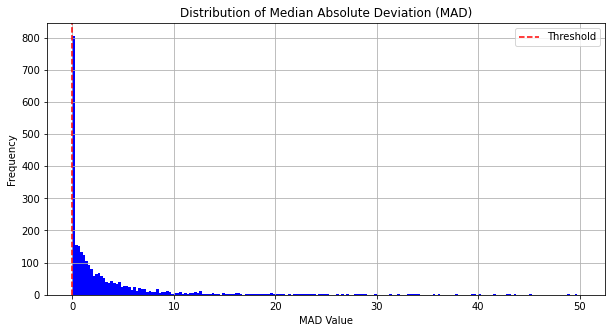

removing 615 genes under the MAD threshold from the dataset
number of genes selected :  2145
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 2853
keeping sample as is, no conversion to time series


In [4]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session
importlib.reload(feature_selection) # to allow modification of the script without restarting the whole session

suggested_genes_file = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'

as_time_series = False
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset(feature_selection_threshold = 10, 
                                                            batch_size = 32, 
                                                            retain_phases = "Both",
                                                            as_time_series = as_time_series,
                                                            MT_removal = False,
                                                            gene_selection_file = suggested_genes_file)

Retaining patients that are included in phases 1 & 2
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 2853 samples
number of genes selected: 1011
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 1299.0999999999995


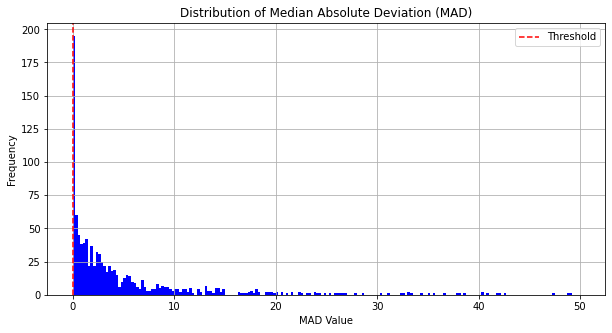

removing 143 genes under the MAD threshold from the dataset
number of genes selected :  868
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 2853
keeping sample as is, no conversion to time series


In [5]:
#now with the other file :
suggested_genes_file = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

as_time_series = False
dataset, index_names, n_genes, gene_names = data_handler.generate_dataset(feature_selection_threshold = 0, 
                                                            batch_size = 32, 
                                                            retain_phases = "Both",
                                                            as_time_series = as_time_series,
                                                            MT_removal = False,
                                                            gene_selection_file = suggested_genes_file)


get the dataset as a numpy object for data manipulation

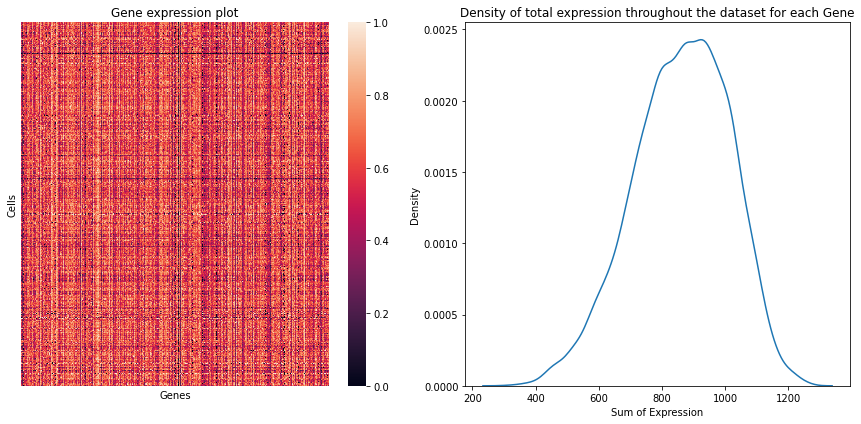

In [4]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
if(as_time_series):
    data = data.reshape(data.shape[0]*data.shape[1], -1)
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = np.repeat(index_names, 5, axis=0)
else:
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = index_names

visualisation.dataset_plot(data)


In [18]:
print(data.head())

name      TOP1  ENSGR0000168939  ENSGR0000214717  ENSGR0000182484   
3442  0.657476         0.680119         0.568290         0.758864  \
3442  0.657249         0.710167         0.640761         0.745283   
3442  0.871234         0.677430         0.630982         0.689887   
3442  0.781621         0.733960         0.596567         0.760155   
3442  0.672427         0.667453         0.566211         0.710165   

name  ENSGR0000198223  ENSGR0000185960  ENSGR0000205755  ENSGR0000185291   
3442         0.307963         0.484549         0.731058         0.735642  \
3442         0.431700         0.614586         0.747578         0.742660   
3442         0.343401         0.693171         0.652476         0.708742   
3442         0.420469         0.490791         0.695181         0.698432   
3442         0.271935         0.319983         0.662539         0.635697   

name  ENSGR0000002586     KIF5A  ...    GARRE1    PTMAP2    TSEN34     MAPK4   
3442         0.406495  0.680119  ...  0.589575  

# Visualisation of the processing pipeline

In [54]:
# preparing the array of input parametter to be tested
# we incrementally add processing steps 

param_sets = [
    {   # vanilla dataset without much processing
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : False, 
        "log1p" : False},

    {   # adding log1p transform
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : False, 
        "log1p" : True},

    {   # adding MT removal
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : True, 
        "log1p" : True},

    {   # keeping only symbols that can be ordered on the dataset and sorting the whole thing
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : True, 
        "log1p" : True, 
        "keep_only_symbols" : True,
        "drop_ambiguous_pos" : True,
        "sort_symbols" : True}
    
    ]

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
number of genes selected :  34569
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


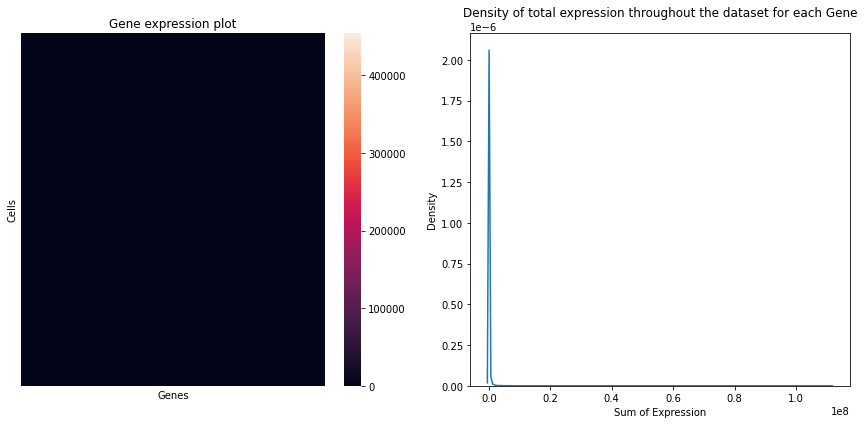

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
number of genes selected :  34569
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


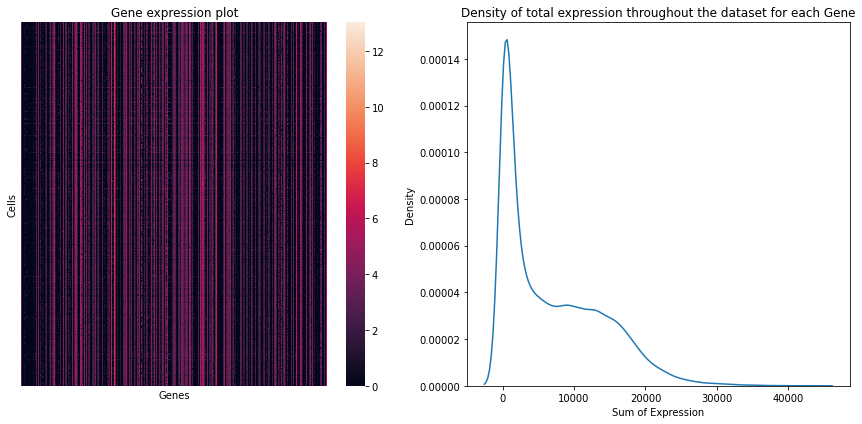

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
number of genes selected :  34271
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


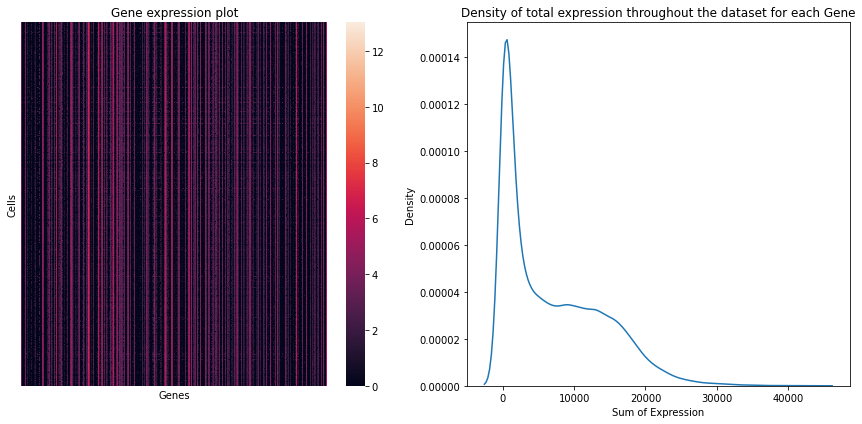

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
removing 6748 not found symbols from the dataset
removing 1506 ambigously positioned symbols from the dataset
number of genes selected :  26017
sorting...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


: 

: 

In [63]:
for params in param_sets:
    dataset, index_names, n_genes, gene_names = data_handler.generate_dataset(**params)
    data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = index_names
    visualisation.dataset_plot(data)

